### Data Preprocessing

In [50]:
import os, json, random, cv2, torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pycocotools.coco import COCO
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import PolynomialLR
from tqdm import tqdm
from collections import defaultdict
import time
import warnings
warnings.filterwarnings("ignore")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [51]:
DATASET_ROOT = Path("/kaggle/input/landfill-detection/LandfillDetection.v1i.coco-segmentation")

TRAIN_IMG_DIR = DATASET_ROOT / "train"
TRAIN_JSON = TRAIN_IMG_DIR / "_annotations.coco.json"

VAL_IMG_DIR = DATASET_ROOT / "valid"
VAL_JSON = VAL_IMG_DIR / "_annotations.coco.json"

TEST_IMG_DIR = DATASET_ROOT / "test"
TEST_JSON = TEST_IMG_DIR / "_annotations.coco.json"

# Verify paths exist
print(f"Dataset Root: {DATASET_ROOT.exists()}")
print(f"Train Images: {TRAIN_IMG_DIR.exists()}")
print(f"Train JSON: {TRAIN_JSON.exists()}")
print(f"Val Images: {VAL_IMG_DIR.exists()}")
print(f"Val JSON: {VAL_JSON.exists()}")
print(f"Test Images: {TEST_IMG_DIR.exists()}")
print(f"Test JSON: {TEST_JSON.exists()}")

Dataset Root: True
Train Images: True
Train JSON: True
Val Images: True
Val JSON: True
Test Images: True
Test JSON: True


In [52]:
print("\nLoading annotations...")
train_coco = COCO(TRAIN_JSON)
val_coco = COCO(VAL_JSON)
test_coco = COCO(TEST_JSON)

print(f"\nTrain images: {len(train_coco.imgs)}")
print(f"Val images: {len(val_coco.imgs)}")
print(f"Test images: {len(test_coco.imgs)}")

print(f"\nTrain annotations: {len(train_coco.anns)}")
print(f"Val annotations: {len(val_coco.anns)}")
print(f"Test annotations: {len(test_coco.anns)}")


Loading annotations...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Train images: 126
Val images: 126
Test images: 31

Train annotations: 159
Val annotations: 159
Test annotations: 35


In [53]:
def get_transforms(is_train=True, size=256):
    """Get image transforms"""
    if is_train:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [54]:
class LandfillSegDataset(Dataset):
    def __init__(self, img_dir, coco, transform=None, size=256, img_ids=None):
        """
        Args:
            img_dir: Directory containing images
            coco: COCO object with annotations
            transform: Image transforms
            size: Target image size
            img_ids: Optional list of image IDs to use (None = use all available)
        """
        self.img_dir = Path(img_dir)
        self.coco = coco
        self.transform = transform
        self.size = size
        self.img_ids = []
        self.selected_img_ids = img_ids

        if not self.img_dir.exists():
            raise ValueError(f"Image directory does not exist: {self.img_dir}")

        self.available_files = {}
        for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
            for f in self.img_dir.glob(ext):
                self.available_files[f.name.lower()] = f.name

        if len(self.available_files) == 0:
            raise ValueError(f"No image files found in {self.img_dir}")

        candidate_ids = img_ids if img_ids is not None else self.coco.imgs.keys()

        skipped = []
        for img_id in candidate_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info["file_name"]
            if "/" in file_name:
                file_name = Path(file_name).name

            if file_name.lower() in self.available_files:
                self.img_ids.append(img_id)
            else:
                skipped.append(file_name)

        print(f"   Dataset initialized: {len(self.img_ids)} images (requested {len(candidate_ids) if img_ids is not None else len(self.coco.imgs)})")

        if skipped:
            print(f"   Warning: {len(skipped)} files requested but not found: {skipped[:5]}...")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
 
        file_name = img_info["file_name"]
        if "/" in file_name:
            file_name = Path(file_name).name

        actual_filename = self.available_files.get(file_name.lower())
        if actual_filename is None:
            raise FileNotFoundError(
                f"Image not found: {file_name}\n"
                f"Looking in: {self.img_dir}\n"
                f"Available files: {len(self.available_files)}"
            )

        img_path = self.img_dir / actual_filename

        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        H, W = img_info["height"], img_info["width"]
        mask = np.zeros((H, W), dtype=np.uint8)
        
        for ann in anns:
            if ann.get("segmentation"):
                if isinstance(ann["segmentation"], list):
                    for seg in ann["segmentation"]:
                        poly = np.array(seg).reshape(-1, 2)
                        cv2.fillPoly(mask, [poly.astype(np.int32)], 1)
                elif isinstance(ann["segmentation"], dict):
                    from pycocotools import mask as mask_util
                    rle = ann["segmentation"]
                    m = mask_util.decode(rle)
                    mask = np.maximum(mask, m)

        mask = Image.fromarray(mask).resize((self.size, self.size), Image.NEAREST)

        if self.transform:
            img = self.transform(img)

        mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float()
        
        return {
            "image": img,
            "mask": mask,
            "name": actual_filename
        }


In [55]:
class SegFormerModel(nn.Module):
    """
    SegFormer wrapper using transformers library (Hugging Face)
    Pre-trained on ADE20K for better semantic segmentation transfer learning
    """
    def __init__(self, num_classes=1, model_name="nvidia/segformer-b2-finetuned-ade-512-512"):
        super().__init__()
        from transformers import SegformerForSemanticSegmentation
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
        self.num_classes = num_classes
        
    def forward(self, x):
        outputs = self.model(pixel_values=x)
        logits = outputs.logits

        logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        return logits

In [56]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation (handles class imbalance)"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """BCE + Dice Loss combination"""
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        
    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + self.dice_weight * self.dice(pred, target)


In [57]:
def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union"""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()


def calculate_dice(pred, target, threshold=0.5):
    """Calculate Dice coefficient"""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
    return dice.item()


def calculate_metrics(pred, target, threshold=0.5):
    """Calculate multiple metrics"""
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    tp = (pred_flat * target_flat).sum().item()
    fp = (pred_flat * (1 - target_flat)).sum().item()
    tn = ((1 - pred_flat) * (1 - target_flat)).sum().item()
    fn = ((1 - pred_flat) * target_flat).sum().item()
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    
    iou = calculate_iou(pred, target, threshold)
    dice = calculate_dice(pred, target, threshold)
    
    return {
        'iou': iou,
        'dice': dice,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [58]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    running_metrics = defaultdict(float)
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        metrics = calculate_metrics(outputs.detach(), masks.detach())
        for k, v in metrics.items():
            running_metrics[k] += v
        
        pbar.set_postfix({
            'loss': loss.item(),
            'iou': metrics['iou']
        })

    n = len(dataloader)
    avg_loss = running_loss / n
    avg_metrics = {k: v / n for k, v in running_metrics.items()}
    avg_metrics['loss'] = avg_loss
    
    return avg_metrics


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    
    running_loss = 0.0
    running_metrics = defaultdict(float)
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
            metrics = calculate_metrics(outputs, masks)
            for k, v in metrics.items():
                running_metrics[k] += v
            
            pbar.set_postfix({
                'loss': loss.item(),
                'iou': metrics['iou']
            })
    
    n = len(dataloader)
    avg_loss = running_loss / n
    avg_metrics = {k: v / n for k, v in running_metrics.items()}
    avg_metrics['loss'] = avg_loss
    
    return avg_metrics

In [59]:
def train_segformer(model, train_dl, val_dl, epochs=50, lr=1e-4, device='cuda'):
    """Complete training pipeline"""
    
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    scheduler = PolynomialLR(optimizer, total_iters=epochs, power=0.9)
    
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    
    scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None
    
    history = {
        'train_loss': [], 'train_iou': [], 'train_dice': [],
        'val_loss': [], 'val_iou': [], 'val_dice': []
    }
    
    best_val_iou = 0.0
    patience_counter = 0
    patience = 10
    
    print(f"\n{'='*60}")
    print(f"Starting SegFormer-B2 Training")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 40)

        start_time = time.time()
        train_metrics = train_epoch(model, train_dl, optimizer, criterion, device, scaler)
        train_time = time.time() - start_time
        
        start_time = time.time()
        val_metrics = validate(model, val_dl, criterion, device)
        val_time = time.time() - start_time
        
        scheduler.step()
        
        print(f"\nTrain - Loss: {train_metrics['loss']:.4f}, IoU: {train_metrics['iou']:.4f}, "
              f"Dice: {train_metrics['dice']:.4f}, Time: {train_time:.1f}s")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, IoU: {val_metrics['iou']:.4f}, "
              f"Dice: {val_metrics['dice']:.4f}, Time: {val_time:.1f}s")

        history['train_loss'].append(train_metrics['loss'])
        history['train_iou'].append(train_metrics['iou'])
        history['train_dice'].append(train_metrics['dice'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_iou'].append(val_metrics['iou'])
        history['val_dice'].append(val_metrics['dice'])
        
        if val_metrics['iou'] > best_val_iou:
            best_val_iou = val_metrics['iou']
            torch.save(model.state_dict(), 'best_segformer_b2.pth')
            print(f"✓ Best model saved! (Val IoU: {best_val_iou:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print(f"\n{'='*60}")
    print(f"Training Complete! Best Val IoU: {best_val_iou:.4f}")
    print(f"{'='*60}\n")
    
    return history

In [60]:
def predict_on_dataloader(model, dataloader, device='cuda', threshold=0.5):
    """Run inference on entire dataloader"""
    model.eval()
    
    predictions = []
    ground_truths = []
    images_list = []
    names_list = []
    
    metrics_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Inference"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            names = batch['name']
            
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()

            batch_metrics = calculate_metrics(outputs, masks, threshold)
            metrics_list.append(batch_metrics)

            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(masks.cpu().numpy())
            images_list.extend(images.cpu().numpy())
            names_list.extend(names)
 
    avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0].keys()}
    
    return {
        'predictions': predictions,
        'ground_truths': ground_truths,
        'images': images_list,
        'names': names_list,
        'metrics': avg_metrics
    }

In [61]:
def visualize_predictions(results, num_samples=8, save_path='predictions.png'):
    """Visualize predictions vs ground truth"""
    
    images = results['images']
    predictions = results['predictions']
    ground_truths = results['ground_truths']
    names = results['names']
    
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    
    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(num_samples):
        img = images[idx] * std + mean
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        
        pred = predictions[idx][0]
        gt = ground_truths[idx][0]
        
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"Image: {names[idx][:20]}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(gt, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred, cmap='gray')
        axes[idx, 2].set_title("Prediction")
        axes[idx, 2].axis('off')
        
        overlay = img.copy()
        overlay[pred > 0.5] = [1, 0, 0]
        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title("Overlay (Red=Waste)")
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved to {save_path}")


def plot_training_history(history, save_path='training_history.png'):
    """Plot training curves"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(history['train_iou'], label='Train IoU', linewidth=2)
    axes[1].plot(history['val_iou'], label='Val IoU', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].set_title('Intersection over Union')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(history['train_dice'], label='Train Dice', linewidth=2)
    axes[2].plot(history['val_dice'], label='Val Dice', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Dice Score')
    axes[2].set_title('Dice Coefficient')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Training history saved to {save_path}")

In [62]:
def measure_efficiency(model, input_size=(1, 3, 256, 256), device='cuda', num_runs=100):
    """Measure model efficiency metrics"""
    
    model = model.to(device)
    model.eval()
    
    dummy_input = torch.randn(input_size).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    try:
        from thop import profile, clever_format
        flops, params = profile(model, inputs=(dummy_input,), verbose=False)
        flops, params = clever_format([flops, params], "%.3f")
    except ImportError:
        flops = "N/A (install thop: pip install thop)"
        params = f"{total_params / 1e6:.2f}M"

    starter = torch.cuda.Event(enable_timing=True)
    ender = torch.cuda.Event(enable_timing=True)

    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            torch.cuda.synchronize()
            timings.append(starter.elapsed_time(ender))
    
    avg_time = np.mean(timings)
    std_time = np.std(timings)
    fps = 1000.0 / avg_time
    
    print(f"\n{'='*60}")
    print(f"SegFormer-B2 Efficiency Metrics")
    print(f"{'='*60}")
    print(f"Total Parameters:     {total_params:,} ({total_params/1e6:.2f}M)")
    print(f"Trainable Parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
    print(f"FLOPs:                {flops}")
    print(f"Inference Time:       {avg_time:.2f} ± {std_time:.2f} ms")
    print(f"Throughput:           {fps:.1f} FPS")
    print(f"{'='*60}\n")
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'flops': flops,
        'inference_time_ms': avg_time,
        'fps': fps
    }

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n{'='*70}")
print(f"SegFormer-B2 Aerial Waste Segmentation")
print(f"{'='*70}")
print(f"Device: {device}\n")

train_coco = COCO(TRAIN_JSON)
test_coco = COCO(TEST_JSON)

all_train_img_ids = list(train_coco.imgs.keys())
train_img_ids, val_img_ids = train_test_split(
    all_train_img_ids, test_size=0.2, random_state=SEED, shuffle=True
)

print(f"Splitting 126 training images → {len(train_img_ids)} train / {len(val_img_ids)} val")

train_ds = LandfillSegDataset(
    img_dir=TRAIN_IMG_DIR,
    coco=train_coco,
    transform=get_transforms(is_train=True, size=256),
    size=256,
    img_ids=train_img_ids
)

val_ds = LandfillSegDataset(
    img_dir=TRAIN_IMG_DIR,
    coco=train_coco,
    transform=get_transforms(is_train=False, size=256),
    size=256,
    img_ids=val_img_ids
)

test_ds = LandfillSegDataset(
    img_dir=TEST_IMG_DIR,
    coco=test_coco,
    transform=get_transforms(is_train=False, size=256),
    size=256
)

BATCH_SIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Final → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
print(f"{'='*70}\n")

print("Loading SegFormer-B2 (ADE20K pre-trained)...")
model = SegFormerModel(num_classes=1, model_name="nvidia/segformer-b2-finetuned-ade-512-512")

efficiency = measure_efficiency(model, input_size=(1, 3, 256, 256), device=device, num_runs=100)

print("Starting training...\n")
history = train_segformer(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=50,
    lr=1e-4,
    device=device
)


SegFormer-B2 Aerial Waste Segmentation
Device: cuda

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Splitting 126 training images → 100 train / 26 val
   Dataset initialized: 100 images (requested 100)
   Dataset initialized: 26 images (requested 26)
   Dataset initialized: 31 images (requested 31)
Final → Train: 100 | Val: 26 | Test: 31

Loading SegFormer-B2 (ADE20K pre-trained)...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



SegFormer-B2 Efficiency Metrics
Total Parameters:     27,347,393 (27.35M)
Trainable Parameters: 27,347,393 (27.35M)
FLOPs:                N/A (install thop: pip install thop)
Inference Time:       23.37 ± 1.35 ms
Throughput:           42.8 FPS

Starting training...


Starting SegFormer-B2 Training


Epoch 1/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s, loss=0.755, iou=0.179]



Train - Loss: 0.8114, IoU: 0.0679, Dice: 0.1268, Time: 2.9s
Val   - Loss: 0.7542, IoU: 0.1723, Dice: 0.2939, Time: 0.5s
✓ Best model saved! (Val IoU: 0.1723)

Epoch 2/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s, loss=0.718, iou=0.254]



Train - Loss: 0.7766, IoU: 0.0998, Dice: 0.1794, Time: 2.9s
Val   - Loss: 0.7174, IoU: 0.2431, Dice: 0.3910, Time: 0.5s
✓ Best model saved! (Val IoU: 0.2431)

Epoch 3/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, loss=0.668, iou=0.298]



Train - Loss: 0.7431, IoU: 0.1389, Dice: 0.2373, Time: 2.9s
Val   - Loss: 0.6679, IoU: 0.3111, Dice: 0.4744, Time: 0.5s
✓ Best model saved! (Val IoU: 0.3111)

Epoch 4/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, loss=0.618, iou=0.482]



Train - Loss: 0.7144, IoU: 0.1606, Dice: 0.2640, Time: 2.9s
Val   - Loss: 0.6228, IoU: 0.4360, Dice: 0.6058, Time: 0.5s
✓ Best model saved! (Val IoU: 0.4360)

Epoch 5/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, loss=0.607, iou=0.398]



Train - Loss: 0.6865, IoU: 0.2475, Dice: 0.3652, Time: 2.9s
Val   - Loss: 0.6086, IoU: 0.4002, Dice: 0.5716, Time: 0.5s

Epoch 6/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, loss=0.579, iou=0.498]



Train - Loss: 0.6759, IoU: 0.1791, Dice: 0.2985, Time: 2.9s
Val   - Loss: 0.5883, IoU: 0.4423, Dice: 0.6112, Time: 0.5s
✓ Best model saved! (Val IoU: 0.4423)

Epoch 7/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, loss=0.559, iou=0.415]



Train - Loss: 0.6574, IoU: 0.2102, Dice: 0.3412, Time: 2.9s
Val   - Loss: 0.5636, IoU: 0.3801, Dice: 0.5499, Time: 0.5s

Epoch 8/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s, loss=0.545, iou=0.487]



Train - Loss: 0.6361, IoU: 0.2060, Dice: 0.3190, Time: 2.9s
Val   - Loss: 0.5496, IoU: 0.4251, Dice: 0.5939, Time: 0.5s

Epoch 9/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.41it/s, loss=0.514, iou=0.519]



Train - Loss: 0.6309, IoU: 0.1785, Dice: 0.2901, Time: 2.9s
Val   - Loss: 0.5247, IoU: 0.4443, Dice: 0.6115, Time: 0.5s
✓ Best model saved! (Val IoU: 0.4443)

Epoch 10/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, loss=0.527, iou=0.482]



Train - Loss: 0.6237, IoU: 0.1754, Dice: 0.2871, Time: 2.9s
Val   - Loss: 0.5371, IoU: 0.3771, Dice: 0.5391, Time: 0.5s

Epoch 11/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, loss=0.48, iou=0.585] 



Train - Loss: 0.6048, IoU: 0.2756, Dice: 0.4177, Time: 2.9s
Val   - Loss: 0.5110, IoU: 0.4915, Dice: 0.6538, Time: 0.5s
✓ Best model saved! (Val IoU: 0.4915)

Epoch 12/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, loss=0.517, iou=0.591]



Train - Loss: 0.6113, IoU: 0.2258, Dice: 0.3571, Time: 2.9s
Val   - Loss: 0.5188, IoU: 0.5678, Dice: 0.7240, Time: 0.5s
✓ Best model saved! (Val IoU: 0.5678)

Epoch 13/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s, loss=0.504, iou=0.533]



Train - Loss: 0.6054, IoU: 0.2676, Dice: 0.4200, Time: 2.9s
Val   - Loss: 0.5124, IoU: 0.5288, Dice: 0.6918, Time: 0.5s

Epoch 14/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, loss=0.528, iou=0.506]



Train - Loss: 0.6100, IoU: 0.1819, Dice: 0.3049, Time: 2.9s
Val   - Loss: 0.5363, IoU: 0.4874, Dice: 0.6552, Time: 0.5s

Epoch 15/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, loss=0.494, iou=0.565]



Train - Loss: 0.5707, IoU: 0.2784, Dice: 0.4209, Time: 2.9s
Val   - Loss: 0.4969, IoU: 0.5635, Dice: 0.7208, Time: 0.5s

Epoch 16/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s, loss=0.461, iou=0.58] 



Train - Loss: 0.5753, IoU: 0.2194, Dice: 0.3375, Time: 2.9s
Val   - Loss: 0.4663, IoU: 0.5542, Dice: 0.7128, Time: 0.5s

Epoch 17/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, loss=0.457, iou=0.583]



Train - Loss: 0.5588, IoU: 0.2561, Dice: 0.3964, Time: 2.9s
Val   - Loss: 0.4646, IoU: 0.5304, Dice: 0.6916, Time: 0.5s

Epoch 18/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, loss=0.447, iou=0.574]



Train - Loss: 0.5608, IoU: 0.2241, Dice: 0.3498, Time: 2.9s
Val   - Loss: 0.4555, IoU: 0.5320, Dice: 0.6935, Time: 0.5s

Epoch 19/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, loss=0.435, iou=0.564]



Train - Loss: 0.5204, IoU: 0.3427, Dice: 0.5089, Time: 2.9s
Val   - Loss: 0.4468, IoU: 0.5129, Dice: 0.6765, Time: 0.5s

Epoch 20/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s, loss=0.407, iou=0.59] 



Train - Loss: 0.5306, IoU: 0.2655, Dice: 0.4096, Time: 2.9s
Val   - Loss: 0.4216, IoU: 0.5459, Dice: 0.7052, Time: 0.5s

Epoch 21/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, loss=0.393, iou=0.603]



Train - Loss: 0.5198, IoU: 0.2955, Dice: 0.4477, Time: 2.9s
Val   - Loss: 0.4072, IoU: 0.5695, Dice: 0.7251, Time: 0.5s
✓ Best model saved! (Val IoU: 0.5695)

Epoch 22/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, loss=0.379, iou=0.624]



Train - Loss: 0.5168, IoU: 0.2838, Dice: 0.4311, Time: 2.9s
Val   - Loss: 0.3988, IoU: 0.5801, Dice: 0.7333, Time: 0.5s
✓ Best model saved! (Val IoU: 0.5801)

Epoch 23/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, loss=0.39, iou=0.619]



Train - Loss: 0.5303, IoU: 0.2096, Dice: 0.3346, Time: 2.9s
Val   - Loss: 0.4047, IoU: 0.5763, Dice: 0.7303, Time: 0.5s

Epoch 24/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, loss=0.396, iou=0.564]



Train - Loss: 0.5212, IoU: 0.2413, Dice: 0.3706, Time: 2.9s
Val   - Loss: 0.4084, IoU: 0.5421, Dice: 0.7028, Time: 0.5s

Epoch 25/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s, loss=0.385, iou=0.558]



Train - Loss: 0.5193, IoU: 0.2383, Dice: 0.3601, Time: 2.9s
Val   - Loss: 0.3963, IoU: 0.5353, Dice: 0.6971, Time: 0.5s

Epoch 26/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, loss=0.407, iou=0.52]



Train - Loss: 0.5128, IoU: 0.2477, Dice: 0.3665, Time: 2.9s
Val   - Loss: 0.4238, IoU: 0.4855, Dice: 0.6530, Time: 0.5s

Epoch 27/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, loss=0.392, iou=0.582]



Train - Loss: 0.5002, IoU: 0.3019, Dice: 0.4559, Time: 2.9s
Val   - Loss: 0.4132, IoU: 0.5181, Dice: 0.6802, Time: 0.5s

Epoch 28/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, loss=0.367, iou=0.574]



Train - Loss: 0.4945, IoU: 0.2787, Dice: 0.4205, Time: 2.9s
Val   - Loss: 0.3808, IoU: 0.5453, Dice: 0.7053, Time: 0.5s

Epoch 29/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, loss=0.378, iou=0.55] 



Train - Loss: 0.4793, IoU: 0.3063, Dice: 0.4597, Time: 2.9s
Val   - Loss: 0.3861, IoU: 0.5190, Dice: 0.6828, Time: 0.5s

Epoch 30/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, loss=0.374, iou=0.52] 



Train - Loss: 0.4698, IoU: 0.3273, Dice: 0.4865, Time: 2.9s
Val   - Loss: 0.3814, IoU: 0.4936, Dice: 0.6606, Time: 0.5s

Epoch 31/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, loss=0.374, iou=0.483]



Train - Loss: 0.4871, IoU: 0.3086, Dice: 0.4644, Time: 2.9s
Val   - Loss: 0.3878, IoU: 0.4606, Dice: 0.6303, Time: 0.5s

Epoch 32/50
----------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, loss=0.383, iou=0.468]


Train - Loss: 0.4686, IoU: 0.3045, Dice: 0.4586, Time: 2.9s
Val   - Loss: 0.3880, IoU: 0.4560, Dice: 0.6262, Time: 0.5s

Early stopping triggered after 32 epochs

Training Complete! Best Val IoU: 0.5801



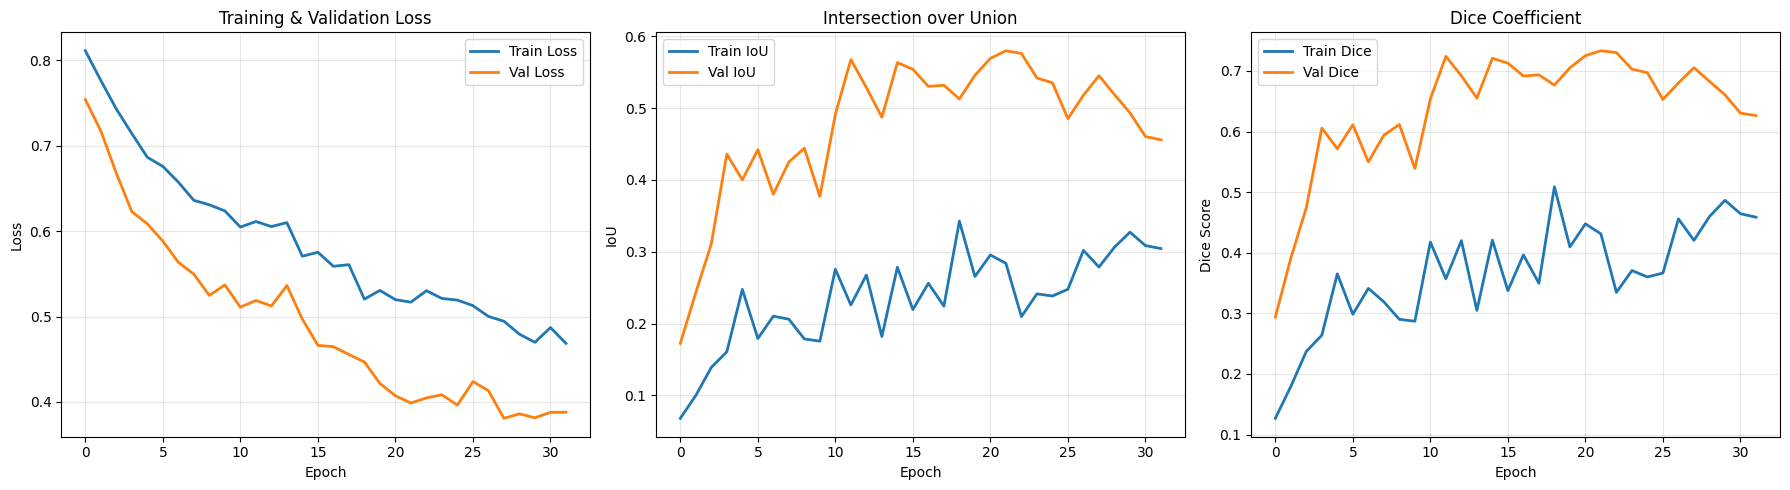

Training history saved to segformer_training_history.png


Inference: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]



TEST SET RESULTS
IOU            : 0.4371
DICE           : 0.6079
PRECISION      : 0.7212
RECALL         : 0.5254
F1             : 0.6079


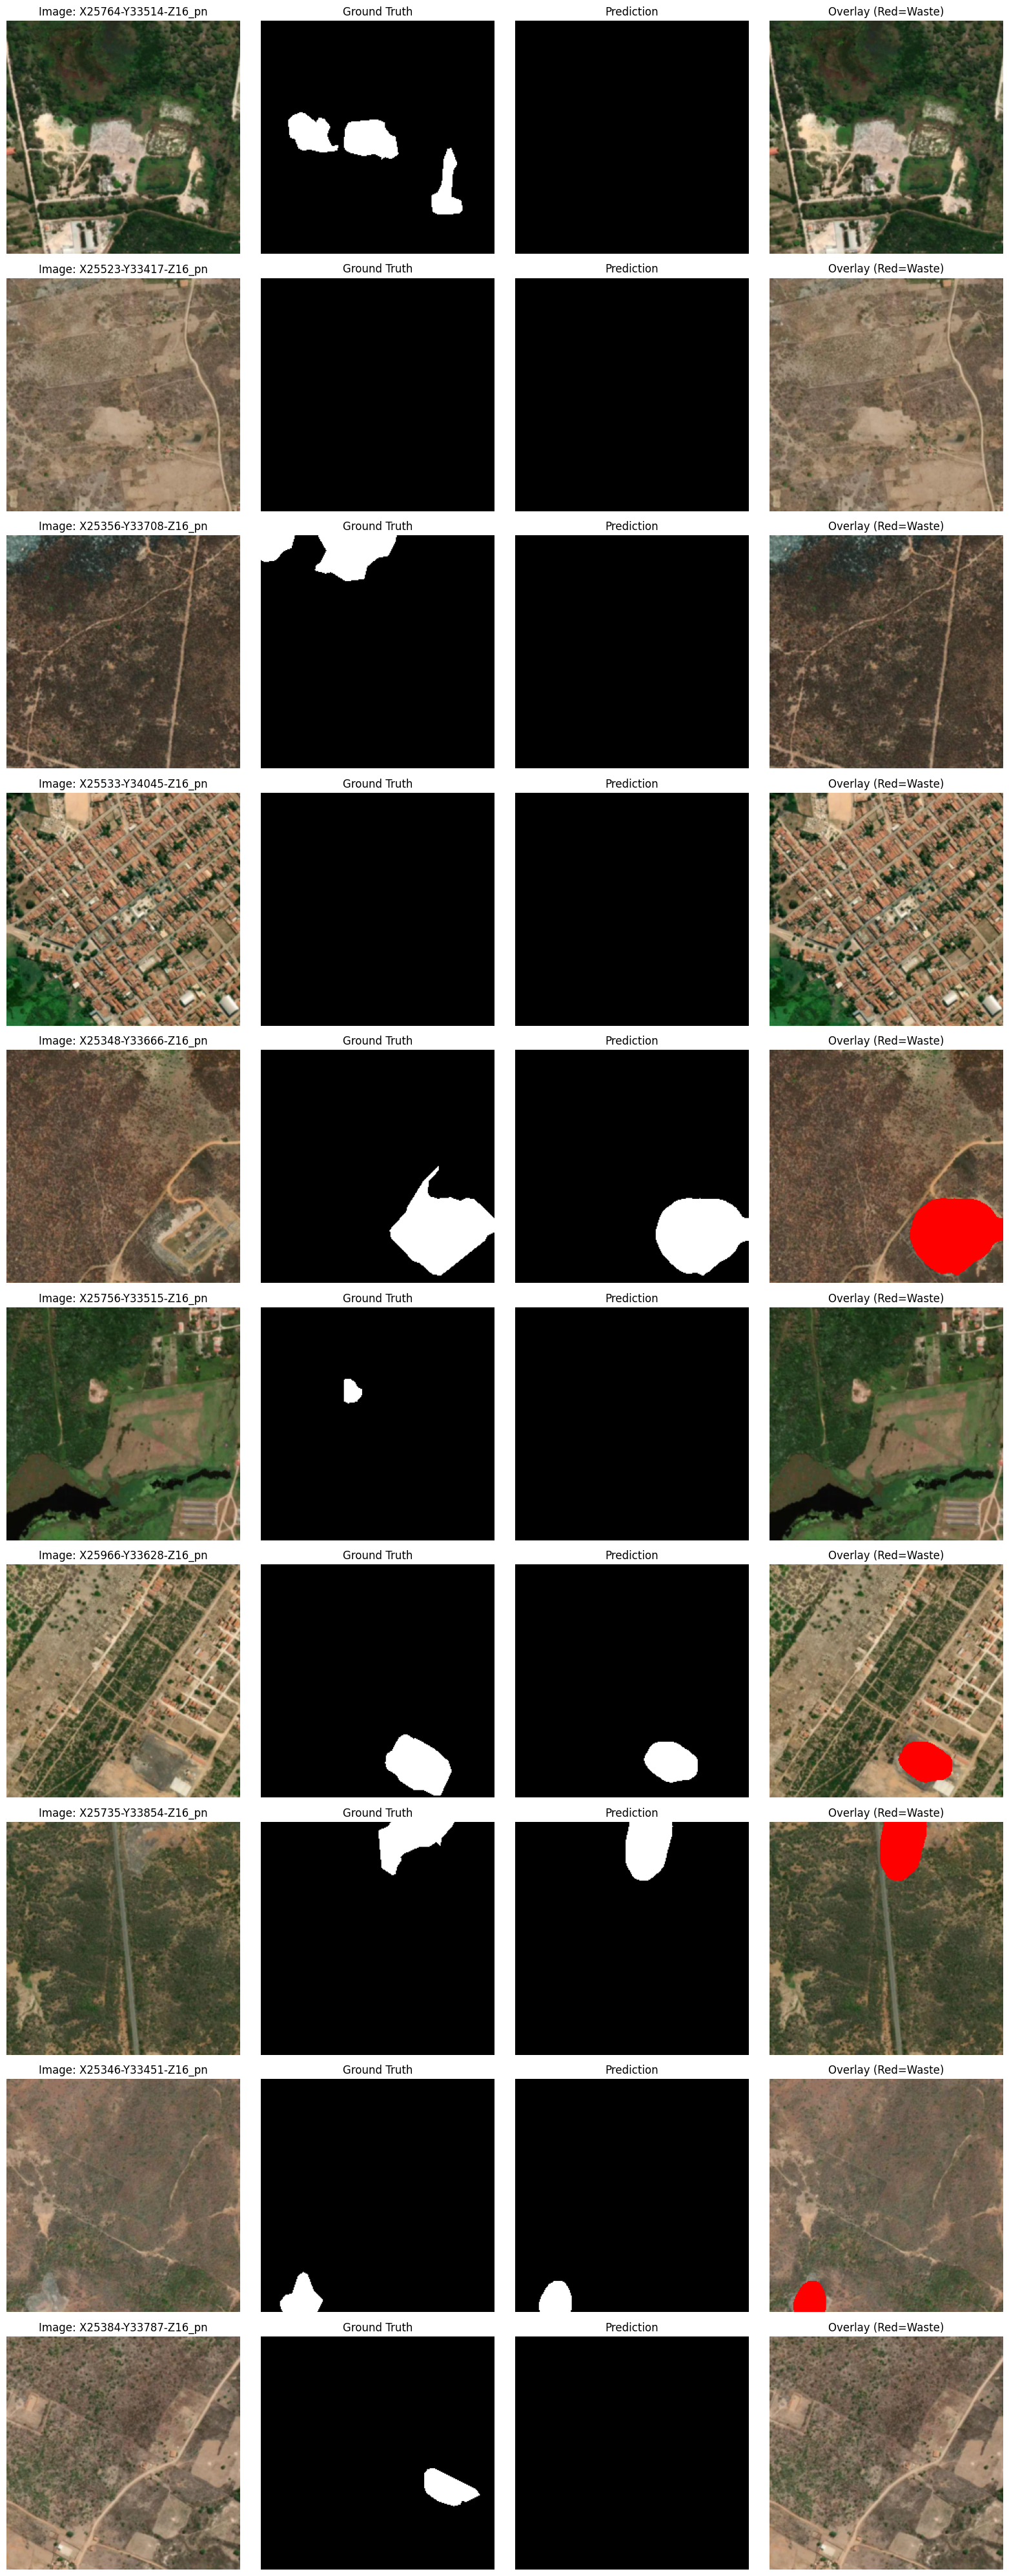

Visualization saved to segformer_predictions.png
Best Val IoU:        0.5801
Best Val Dice:       0.7333
Final Test IoU:      0.4371
Final Test Dice:     0.6079
Final Test Precision: 0.7212
Final Test Recall:   0.5254
Final Test F1:       0.6079

Model Parameters:    27,347,393
Inference Speed:     42.8 FPS

Saved Files:
  - best_segformer_b2.pth (model weights)
  - segformer_training_history.png (training curves)
  - segformer_predictions.png (visualizations)


In [64]:
plot_training_history(history, save_path='segformer_training_history.png')

model.load_state_dict(torch.load('best_segformer_b2.pth'))
test_results = predict_on_dataloader(model, test_dl, device=device, threshold=0.5)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
for metric, value in test_results['metrics'].items():
    print(f"{metric.upper():15s}: {value:.4f}")
print("="*70)

visualize_predictions(test_results, num_samples=10, save_path='segformer_predictions.png')

print("="*70)
print(f"Best Val IoU:        {max(history['val_iou']):.4f}")
print(f"Best Val Dice:       {max(history['val_dice']):.4f}")
print(f"Final Test IoU:      {test_results['metrics']['iou']:.4f}")
print(f"Final Test Dice:     {test_results['metrics']['dice']:.4f}")
print(f"Final Test Precision: {test_results['metrics']['precision']:.4f}")
print(f"Final Test Recall:   {test_results['metrics']['recall']:.4f}")
print(f"Final Test F1:       {test_results['metrics']['f1']:.4f}")
print(f"\nModel Parameters:    {efficiency['total_params']:,}")
print(f"Inference Speed:     {efficiency['fps']:.1f} FPS")
print(f"\nSaved Files:")
print(f"  - best_segformer_b2.pth (model weights)")
print(f"  - segformer_training_history.png (training curves)")
print(f"  - segformer_predictions.png (visualizations)")
print("="*70)